In [1]:
import sys
import os
import collections
import csv
import argparse
import random
import re
import emoji
import pickle

import xml.etree.ElementTree as et
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
import torch.nn as nn
import transformers

from datetime import datetime
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from load import *

from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW
#from transformers import BertTokenizer, BertModel
#from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
#                              TensorDataset)
# pass the pre-trained BERT to our define architecture

# push the model to GPU
device = torch.device("cuda")

In [2]:
#import bert pre-trained model
bert = AutoModel.from_pretrained('bert-base-uncased')
#load the bert tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [3]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False


In [4]:
#defining the architecture
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      #print (cls_hs)
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [5]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [6]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)          # learning rate

In [7]:
year=2017
processed_train_dir = "/projets/sig/mullah/nlp/depression/data/processed/"+str(year)+"/train/"
processed_test_dir = "/projets/sig/mullah/nlp/depression/data/processed/"+str(year)+"/test/"
models_dir = "/projets/sig/mullah/nlp/depression/models/"+str(year)+"/bert"
df = pd.read_csv(os.path.join(processed_train_dir, "train_texts"))
df = df.dropna()
df.head()

,labels,texts
0,0,"Actually, there isn't anything reasonable that..."
1,0,if a foreign terrorist had committed this atta...
2,0,worth a dismissive news segment?. . what are y...
3,0,Why do you think the nose is fake?
4,0,its not uncommon for there to be 10+ or even 3...


In [8]:
# split train dataset into train, validation and test sets
train_text, val_text, train_labels, val_labels = train_test_split(df['texts'], df['labels'], 
                                                                    random_state=42, 
                                                                    test_size=0.2, 
                                                                    stratify=df['labels'])
print (len(train_text))
print (train_text.head())
print (len(val_text))
print (val_text.head())

168588
125497    I'm not sure how you ended up there. My link w...
93754     That's the excuse. When CU was snubbed they lo...
142815    This is what you get from the GOP.  Care about...
16070                                              *shhhhh*
208644          The scissor scene at the end is what got me
Name: texts, dtype: object
42148
55786     http://www.reactiongifs.com/wp-content/uploads...
152872                                            A Twinkie
146112    Yeah.. i'm thinking I may take note of the pla...
112701    I do repost it with Ars Technica article today...
41041         Tried to pretend I was straight and cis. Lel.
Name: texts, dtype: object


<AxesSubplot:>

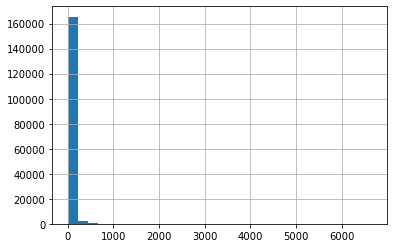

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [15]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 128,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 128,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
#tokens_test = tokenizer.batch_encode_plus(
#    test_text.tolist(),
#    max_length = 25,
#    pad_to_max_length=True,
#    truncation=True
#)

In [16]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids']) ;,l
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

#test_seq = torch.tensor(tokens_test['input_ids'])
#test_mask = torch.tensor(tokens_test['attention_mask'])
#test_y = torch.tensor(test_labels.tolist())

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [18]:
#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print("Class Weights:",class_weights)

Class Weights: [0.57687017 3.75223681]


/users/sig/mullah/.conda/envs/e36t11/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=125497    0
93754     0
142815    0
16070     0
208644    1
         ..
92994     0
94349     0
132760    0
186933    1
165545    0
Name: labels, Length: 168588, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [19]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights, dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [20]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [21]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# number of training epochs
epochs = 5

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_path = os.path.join(models_dir, 'saved_weights.pt')
        torch.save(model.state_dict(), model_path)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of  5,269.
  Batch   100  of  5,269.
  Batch   150  of  5,269.
  Batch   200  of  5,269.
  Batch   250  of  5,269.
  Batch   300  of  5,269.
  Batch   350  of  5,269.
  Batch   400  of  5,269.
  Batch   450  of  5,269.
  Batch   500  of  5,269.
  Batch   550  of  5,269.
  Batch   600  of  5,269.
  Batch   650  of  5,269.
  Batch   700  of  5,269.
  Batch   750  of  5,269.
  Batch   800  of  5,269.
  Batch   850  of  5,269.
  Batch   900  of  5,269.
  Batch   950  of  5,269.
  Batch 1,000  of  5,269.
  Batch 1,050  of  5,269.
  Batch 1,100  of  5,269.
  Batch 1,150  of  5,269.
  Batch 1,200  of  5,269.
  Batch 1,250  of  5,269.
  Batch 1,300  of  5,269.
  Batch 1,350  of  5,269.
  Batch 1,400  of  5,269.
  Batch 1,450  of  5,269.
  Batch 1,500  of  5,269.
  Batch 1,550  of  5,269.
  Batch 1,600  of  5,269.
  Batch 1,650  of  5,269.
  Batch 1,700  of  5,269.
  Batch 1,750  of  5,269.
